In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

C:\Users\ryann\AppData\Local\Temp\ipykernel_10468\3187129209.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


some notes 
- df_field contains 'Field' sample types (9616 obs out of 28848)
- there are 16 unique samples; each sample contains 601 distinct taxonomy (601*16 = 9616)
    - 16 of 9616 are unknown; rest are bacteria (8512) or archaea (1088) 
    - 100 distinct phylum, 246 distinct class, 600 distinct order
- samples are split into lake (Inre, Villa), edge (center, edge), and depth (2, 6, 10, 14)

In [2]:
# read dataset and filter for field samples 
df = pd.read_csv('microbe_data.csv')
df = df.iloc[:, 1:] # drop first col 
df_field = df[df['SampleType'] == 'Field'][['taxonomy', 'sample', 'Abundance', 'Lake', 'Edge', 'Depth', 'SampleType']]

# split the taxonomy column
tax_split = df_field['taxonomy'].str.split(';', expand=True)
tax_split.columns = ['Root', 'domain', 'phylum', 'class', 'order']
for col in ['domain', 'phylum', 'class', 'order']:
    tax_split[col] = tax_split[col].str.strip().str.replace(r'^[dpco]__', '', regex=True)
df_field = pd.concat([df_field, tax_split[['domain', 'phylum', 'class', 'order']]], axis=1)

df_field.head()

# run the following / change the parameters to see counts 
# df_field['Edge'].value_counts()
# df_field['Lake'].value_counts()
# df_field['Depth'].value_counts()

,taxonomy,sample,Abundance,Lake,Edge,Depth,SampleType,domain,phylum,class,order
0,Root; d__Archaea; p__Aenigmatarchaeota; c__Aen...,Inre_C_10_12,0.000000,Inre,Center,10,Field,Archaea,Aenigmatarchaeota,Aenigmatarchaeia,Aenigmatarchaeales
1,Root; d__Archaea; p__Aenigmatarchaeota; c__Aen...,Inre_C_14_16,0.650564,Inre,Center,14,Field,Archaea,Aenigmatarchaeota,Aenigmatarchaeia,Aenigmatarchaeales
2,Root; d__Archaea; p__Aenigmatarchaeota; c__Aen...,Inre_C_2_4,0.115520,Inre,Center,2,Field,Archaea,Aenigmatarchaeota,Aenigmatarchaeia,Aenigmatarchaeales
3,Root; d__Archaea; p__Aenigmatarchaeota; c__Aen...,Inre_C_6_8,0.000000,Inre,Center,6,Field,Archaea,Aenigmatarchaeota,Aenigmatarchaeia,Aenigmatarchaeales
4,Root; d__Archaea; p__Aenigmatarchaeota; c__Aen...,Inre_E_14_16,0.000000,Inre,Edge,14,Field,Archaea,Aenigmatarchaeota,Aenigmatarchaeia,Aenigmatarchaeales


Here I create a wide dataframe (df_phylum_wide) containing 16 rows (per sample) and 105 columns (100 of which are phylum abundance) <br>
Then I run PCA with 16 samples and 100 phylum abundances <br>
**RQ: ???**

In [3]:
# group by sample and phylum (sum abundance by phylum)
df_phylum = (
    df_field
    .groupby(['sample', 'phylum', 'Lake', 'Edge', 'Depth', 'SampleType'], as_index=False)['Abundance']
    .sum()
)
# pivot (one col per phylum)
df_phylum_wide = df_phylum.pivot_table(
    index=['sample', 'Lake', 'Edge', 'Depth', 'SampleType'],  # one row per sample
    columns='phylum',
    values='Abundance',
    fill_value=0  # fill missing phyla with 0 abundance
).reset_index()
df_phylum_wide.columns.name = None
df_phylum_wide.head()


,sample,Lake,Edge,Depth,SampleType,4484-113,Acidobacteriota,Actinomycetota,Aenigmatarchaeota,Altiarchaeota,...,UBA1439,UBA3054,UBA6262,UBP14,UBP15,UBP4,VGIX01,Verrucomicrobiota,WOR-3,Zixibacteria
0,Inre_C_10_12,Inre,Center,10,Field,0.017288,6.311236,2.550339,0.031550,0.159045,...,0.411010,0.000000,0.000000,0.00000,0.088166,0.00000,0.000000,3.045626,0.201399,0.849249
1,Inre_C_14_16,Inre,Center,14,Field,0.055952,3.863552,1.596537,1.762971,0.469904,...,0.021812,0.055952,0.000000,0.00000,0.050736,0.08867,0.032244,2.454788,0.319592,0.812731
2,Inre_C_2_4,Inre,Center,2,Field,0.020039,4.666172,3.998986,0.350685,0.357758,...,0.000000,0.000000,0.030059,0.00000,0.023575,0.00000,0.026522,3.974821,0.253436,0.340665
3,Inre_C_6_8,Inre,Center,6,Field,0.027676,6.066444,11.671623,0.105820,0.104734,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,2.777356,0.137837,0.213810
4,Inre_E_14_16,Inre,Edge,14,Field,0.010479,5.489459,1.591299,0.300521,0.115268,...,0.177767,0.000000,0.000000,0.01497,0.141465,0.00000,0.000000,2.602141,0.234279,1.117502


In [4]:
# perform PCA with 16 samples and 100 phylum abundance ('phylum space') 
phylum_cols = df_phylum_wide.columns.difference(['sample', 'Lake', 'Edge', 'Depth', 'SampleType'])
X1 = df_phylum_wide[phylum_cols].to_numpy() # 16, 100 
pca1 = PCA()                               
PCs1 = pca1.fit_transform(X1.T)               # 16 PCs, 16 elements each                   
eigvecs1 = pca1.components_                 # 16 eigenvectors, 100 elements each      
fracVar1 = pca1.explained_variance_ratio_   # note first 3 modes explain >80% of variance

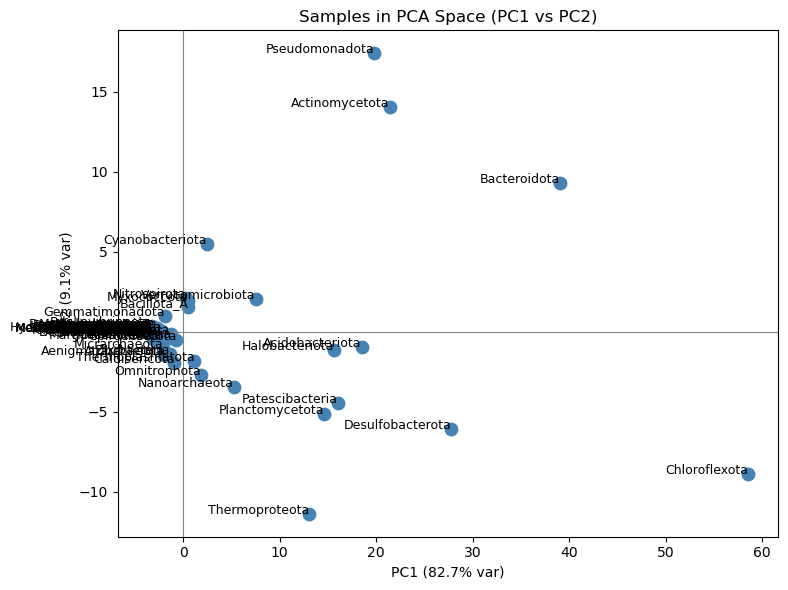

In [5]:
sample_labels = df_phylum_wide['sample'].astype(str).values
phylum_labels = list(phylum_cols)  

# Assume you already have: PCs1 (shape 16x16), sample_labels, fracVar1
plt.figure(figsize=(8, 6))

# Scatter plot for first two PCs
plt.scatter(PCs1[:, 0], PCs1[:, 1], s=80, color='steelblue')

# Annotate each point with the sample label
for i, label in enumerate(phylum_labels):
    plt.text(PCs1[i, 0], PCs1[i, 1], label, fontsize=9, ha='right')

# Axis labels and title
plt.xlabel(f'PC1 ({fracVar1[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({fracVar1[1]*100:.1f}% var)')
plt.title('Samples in PCA Space (PC1 vs PC2)')

plt.axhline(0, color='gray', linewidth=0.8)
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()


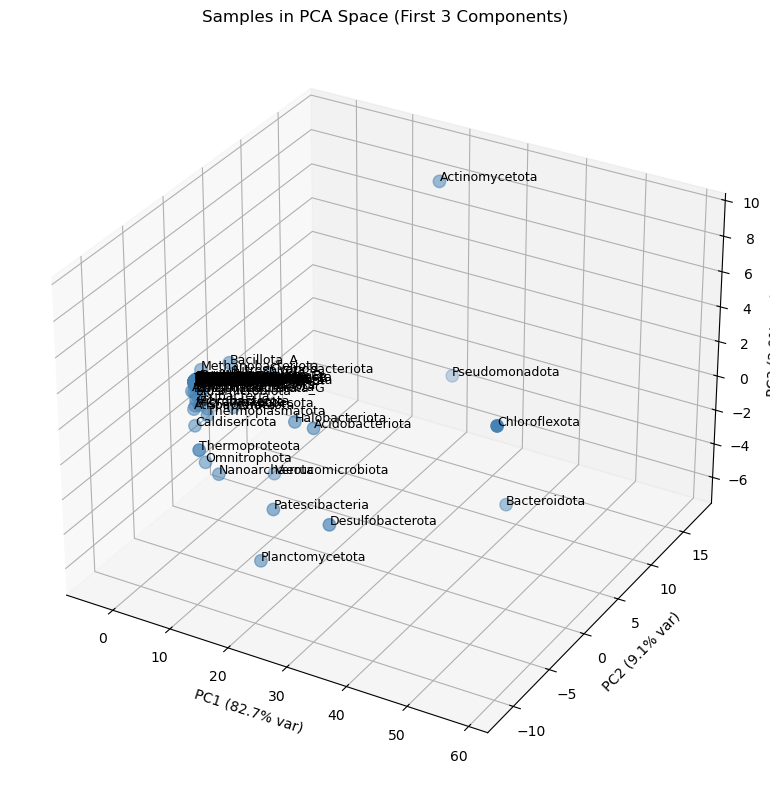

In [6]:
from mpl_toolkits.mplot3d import Axes3D  # activates 3D plotting

# Assume you already have: PCs1 (shape 16x16), sample_labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter: first three PCs
ax.scatter(
    PCs1[:, 0],  # PC1
    PCs1[:, 1],  # PC2
    PCs1[:, 2],  # PC3
    s=80,        # marker size
    color='steelblue'
)

# Annotate each point with the sample name
for i, label in enumerate(phylum_labels):
    ax.text(PCs1[i, 0], PCs1[i, 1], PCs1[i, 2], label, fontsize=9)

# Axis labels
ax.set_xlabel(f'PC1 ({fracVar1[0]*100:.1f}% var)')
ax.set_ylabel(f'PC2 ({fracVar1[1]*100:.1f}% var)')
ax.set_zlabel(f'PC3 ({fracVar1[2]*100:.1f}% var)')
ax.set_title("Samples in PCA Space (First 3 Components)")

plt.tight_layout()
plt.show()
